In [1]:
# Import data from Excel sheet
import pandas as pd
df = pd.read_excel('aibl_ptdemog_final.xlsx', sheet_name='aibl_ptdemog_final')
#print(df)
sid = df['RID']
grp = df['DXCURREN']
age = df['age']
sex = df['PTGENDER(1=Male)']
tiv = df['Total'] # TIV
field = df['field_strength']
grpbin = (grp > 1) # 1=CN, ...
amy_bin = df['conversion_CL_threshold_26']

In [2]:
# Scan for nifti file names
import glob
dataAIBL = sorted(glob.glob('mwp1_MNI_AIBL/*.nii.gz'))
dataFiles = dataAIBL
numfiles = len(dataFiles)
print('Found ', str(numfiles), ' nifti files')

Found  606  nifti files


In [3]:
# Match covariate information
import re
debug = False
cov_idx = [-1] * numfiles # list; array: np.full((numfiles, 1), -1, dtype=int)
print('Matching covariates for loaded files ...')
for i,id in enumerate(sid):
  p = [j for j,x in enumerate(dataFiles) if re.search('_%d_MR_' % id, x)] # extract ID numbers from filename, translate to Excel row index
  if len(p)==0:
    if debug: print('Did not find %04d' % id) # did not find Excel sheet subject ID in loaded file selection
  else:
    if debug: print('Found %04d in %s: %s' % (id, p[0], dataFiles[p[0]]))
    cov_idx[p[0]] = i # store Excel index i for data file index p[0]
print('Checking for scans not found in Excel sheet: ', sum(x<0 for x in cov_idx))

labels = pd.DataFrame({'Group':grpbin}).iloc[cov_idx, :]
grps = pd.DataFrame({'Group':grp, 'RID':sid}).iloc[cov_idx, :]
amy_status = pd.DataFrame({'amy_pos':amy_bin}).iloc[cov_idx, :]

Matching covariates for loaded files ...
Checking for scans not found in Excel sheet:  0


In [4]:
# Load residualized data from disk
import h5py
import numpy as np
from pandas import DataFrame
from keras.utils import to_categorical
hf = h5py.File('residuals_wb_mwp1_MNI_AIBL.hdf5', 'r')
hf.keys # read keys
#labels = np.array(hf.get('labels')) # note: was of data frame type before
images = np.array(hf.get('images'))
hf.close()
#labels = to_categorical(np.asarray(labels)) # use grps to access original labels
print(images.shape)

Using TensorFlow backend.


(606, 100, 100, 120, 1)


In [5]:
# filter scans by amyloid status
labels = to_categorical(np.asarray(labels)) # use grps to access original labels
amy_filter = np.equal(np.transpose(amy_status.to_numpy()), labels[:,1])

# drop participants/entries by amy_filter
#dataFiles = [i for (i, v) in zip(dataFiles, np.squeeze(amy_filter)) if v] # filter list of files
#cov_idx = [i for (i, v) in zip(cov_idx, np.squeeze(amy_filter)) if v] # filter list of excel row indices
#labels = labels[np.squeeze(amy_filter), :]
#grps = grps.iloc[np.squeeze(amy_filter)]
#numfiles = len(dataFiles)
#print('Kept ', str(numfiles), ' nifti files')

In [6]:
# specify version of tensorflow
#%tensorflow_version 1.x
#%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
# disable tensorflow deprecation warnings
import logging
logging.getLogger('tensorflow').disabled=True
# downgrade to specific version
#!pip install tensorflow-gpu==1.15
#import tensorflow as tf
#print(tf.__version__)
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto(
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
    # device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = False #True
session = tf.Session(config=config)
set_session(session)

1.15.0


In [7]:
def get_values(conf_matrix):
    assert conf_matrix.shape==(2,2)
    tn, fp, fn, tp = conf_matrix.ravel()
    sen = tp / (tp+fn)
    spec = tn / (fp+tn)
    ppv = tp / (tp+fp)
    npv = tn / (tn+fn)
    f1 = 2 * ((sen * spec) / (sen + spec))
    return sen, spec, ppv, npv, f1

validating model newmodel/newmodel_wb_cv1.hdf5
Test accuracy: 76.36 %


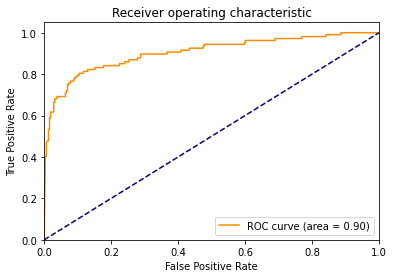

Optimal prediction threshold: 0.97188
Optimal prediction threshold: 0.99070
AUC for MCI vs. CN = 0.85
AUC for AD vs. CN = 0.96
AUC for MCI vs. CN = 0.851
AUC for AD vs. CN = 0.958
Acc for MCI vs. CN = 73.8
Acc for AD vs. CN = 75.9
confusion matrix (naive)
[[230  86]
 [ 11  43]
 [  3  50]]
oAcc for MCI vs. CN = 86.8
oAcc for AD vs. CN = 92.4
confusion matrix (optimized)
[[285  31]
 [ 18  36]
 [  5  48]]
validating model newmodel/newmodel_wb_cv2.hdf5
Test accuracy: 68.32 %


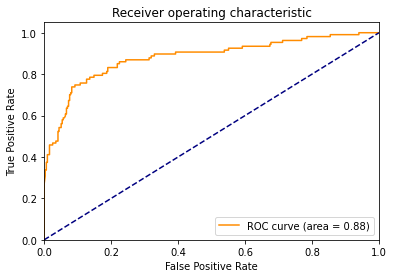

Optimal prediction threshold: 0.99234
Optimal prediction threshold: 0.98792
AUC for MCI vs. CN = 0.82
AUC for AD vs. CN = 0.94
AUC for MCI vs. CN = 0.818
AUC for AD vs. CN = 0.944
Acc for MCI vs. CN = 64.1
Acc for AD vs. CN = 66.4
confusion matrix (naive)
[[193 123]
 [ 10  44]
 [  1  52]]
oAcc for MCI vs. CN = 87.6
oAcc for AD vs. CN = 89.7
confusion matrix (optimized)
[[290  26]
 [ 20  34]
 [  9  44]]
validating model newmodel/newmodel_wb_cv3.hdf5
Test accuracy: 75.89 %


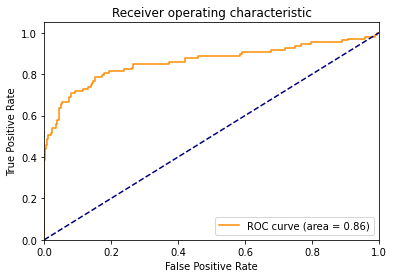

Optimal prediction threshold: 0.92061
Optimal prediction threshold: 0.99113
AUC for MCI vs. CN = 0.76
AUC for AD vs. CN = 0.96
AUC for MCI vs. CN = 0.762
AUC for AD vs. CN = 0.958
Acc for MCI vs. CN = 73.0
Acc for AD vs. CN = 76.2
confusion matrix (naive)
[[230  86]
 [ 14  40]
 [  2  51]]
oAcc for MCI vs. CN = 81.6
oAcc for AD vs. CN = 91.9
confusion matrix (optimized)
[[268  48]
 [ 20  34]
 [  5  48]]
validating model newmodel/newmodel_wb_cv4.hdf5
Test accuracy: 75.41 %


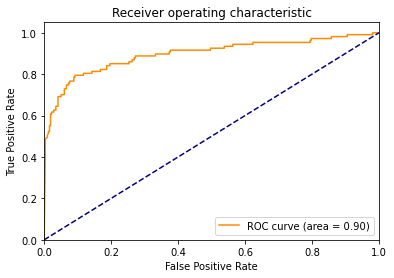

Optimal prediction threshold: 0.98656
Optimal prediction threshold: 0.98557
AUC for MCI vs. CN = 0.83
AUC for AD vs. CN = 0.96
AUC for MCI vs. CN = 0.831
AUC for AD vs. CN = 0.963
Acc for MCI vs. CN = 72.2
Acc for AD vs. CN = 74.8
confusion matrix (naive)
[[224  92]
 [ 11  43]
 [  1  52]]
oAcc for MCI vs. CN = 87.0
oAcc for AD vs. CN = 91.1
confusion matrix (optimized)
[[288  28]
 [ 20  34]
 [  4  49]]
validating model newmodel/newmodel_wb_cv5.hdf5
Test accuracy: 76.12 %


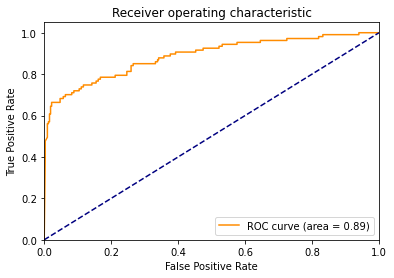

Optimal prediction threshold: 0.99992
Optimal prediction threshold: 0.98667
AUC for MCI vs. CN = 0.82
AUC for AD vs. CN = 0.95
AUC for MCI vs. CN = 0.821
AUC for AD vs. CN = 0.954
Acc for MCI vs. CN = 73.5
Acc for AD vs. CN = 77.0
confusion matrix (naive)
[[234  82]
 [ 16  38]
 [  3  50]]
oAcc for MCI vs. CN = 91.1
oAcc for AD vs. CN = 90.5
confusion matrix (optimized)
[[309   7]
 [ 26  28]
 [ 12  41]]
validating model newmodel/newmodel_wb_cv6.hdf5
Test accuracy: 69.74 %


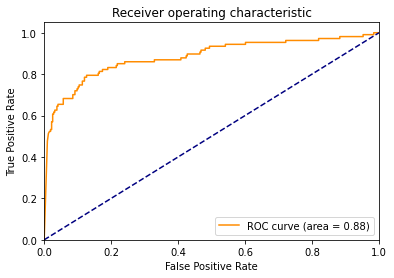

Optimal prediction threshold: 0.98652
Optimal prediction threshold: 0.99434
AUC for MCI vs. CN = 0.81
AUC for AD vs. CN = 0.96
AUC for MCI vs. CN = 0.812
AUC for AD vs. CN = 0.957
Acc for MCI vs. CN = 65.9
Acc for AD vs. CN = 68.6
confusion matrix (naive)
[[202 114]
 [ 12  42]
 [  2  51]]
oAcc for MCI vs. CN = 84.3
oAcc for AD vs. CN = 88.6
confusion matrix (optimized)
[[276  40]
 [ 18  36]
 [  5  48]]
validating model newmodel/newmodel_wb_cv7.hdf5
Test accuracy: 79.91 %


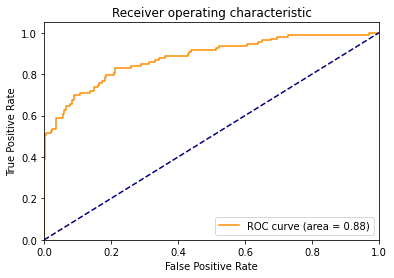

Optimal prediction threshold: 0.40610
Optimal prediction threshold: 0.99461
AUC for MCI vs. CN = 0.80
AUC for AD vs. CN = 0.96
AUC for MCI vs. CN = 0.802
AUC for AD vs. CN = 0.960
Acc for MCI vs. CN = 77.8
Acc for AD vs. CN = 82.1
confusion matrix (naive)
[[253  63]
 [ 19  35]
 [  3  50]]
oAcc for MCI vs. CN = 77.3
oAcc for AD vs. CN = 91.1
confusion matrix (optimized)
[[249  67]
 [ 17  37]
 [  2  51]]
validating model newmodel/newmodel_wb_cv8.hdf5
Test accuracy: 76.60 %


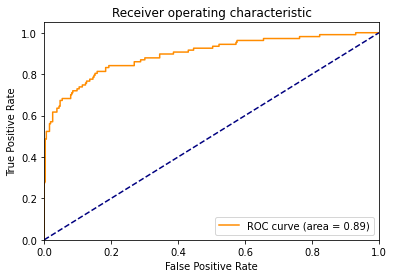

Optimal prediction threshold: 0.90107
Optimal prediction threshold: 0.87273
AUC for MCI vs. CN = 0.84
AUC for AD vs. CN = 0.95
AUC for MCI vs. CN = 0.841
AUC for AD vs. CN = 0.950
Acc for MCI vs. CN = 74.1
Acc for AD vs. CN = 77.0
confusion matrix (naive)
[[234  82]
 [ 14  40]
 [  3  50]]
oAcc for MCI vs. CN = 82.7
oAcc for AD vs. CN = 85.1
confusion matrix (optimized)
[[269  47]
 [ 17  37]
 [  6  47]]
validating model newmodel/newmodel_wb_cv9.hdf5
Test accuracy: 81.80 %


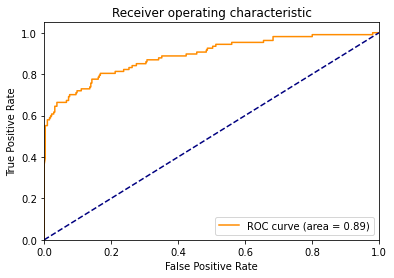

Optimal prediction threshold: 0.99714
Optimal prediction threshold: 0.71662
AUC for MCI vs. CN = 0.81
AUC for AD vs. CN = 0.97
AUC for MCI vs. CN = 0.811
AUC for AD vs. CN = 0.968
Acc for MCI vs. CN = 79.7
Acc for AD vs. CN = 84.3
confusion matrix (naive)
[[260  56]
 [ 19  35]
 [  2  51]]
oAcc for MCI vs. CN = 90.0
oAcc for AD vs. CN = 86.7
confusion matrix (optimized)
[[306  10]
 [ 27  27]
 [ 13  40]]
validating model newmodel/newmodel_wb_cv10.hdf5
Test accuracy: 70.21 %


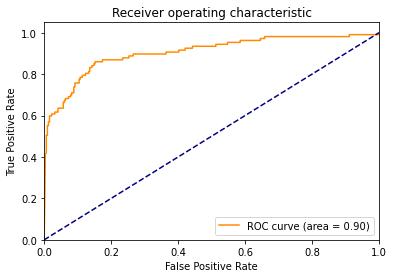

Optimal prediction threshold: 0.92564
Optimal prediction threshold: 0.94241
AUC for MCI vs. CN = 0.85
AUC for AD vs. CN = 0.96
AUC for MCI vs. CN = 0.850
AUC for AD vs. CN = 0.961
Acc for MCI vs. CN = 66.2
Acc for AD vs. CN = 68.6
confusion matrix (naive)
[[201 115]
 [ 10  44]
 [  1  52]]
oAcc for MCI vs. CN = 83.2
oAcc for AD vs. CN = 86.4
confusion matrix (optimized)
[[268  48]
 [ 14  40]
 [  2  51]]
validating model newmodel/newmodel_wb_cv11.hdf5
Test accuracy: 70.92 %


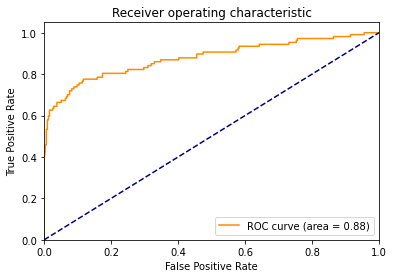

Optimal prediction threshold: 0.98454
Optimal prediction threshold: 0.99351
AUC for MCI vs. CN = 0.80
AUC for AD vs. CN = 0.96
AUC for MCI vs. CN = 0.798
AUC for AD vs. CN = 0.959
Acc for MCI vs. CN = 67.3
Acc for AD vs. CN = 70.2
confusion matrix (naive)
[[208 108]
 [ 13  41]
 [  2  51]]
oAcc for MCI vs. CN = 84.6
oAcc for AD vs. CN = 90.0
confusion matrix (optimized)
[[279  37]
 [ 20  34]
 [  5  48]]
validating model newmodel/newmodel_wb_cv12.hdf5
Test accuracy: 73.76 %


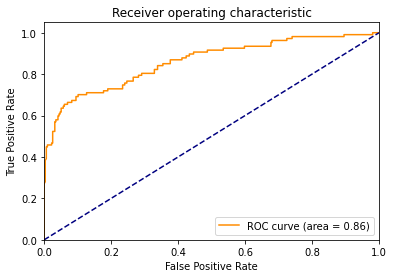

Optimal prediction threshold: 0.95440
Optimal prediction threshold: 0.99630
AUC for MCI vs. CN = 0.77
AUC for AD vs. CN = 0.95
AUC for MCI vs. CN = 0.772
AUC for AD vs. CN = 0.950
Acc for MCI vs. CN = 71.1
Acc for AD vs. CN = 75.1
confusion matrix (naive)
[[228  88]
 [ 19  35]
 [  4  49]]
oAcc for MCI vs. CN = 84.3
oAcc for AD vs. CN = 92.4
confusion matrix (optimized)
[[284  32]
 [ 26  28]
 [  7  46]]
validating model newmodel/newmodel_wb_cv13.hdf5
Test accuracy: 84.16 %


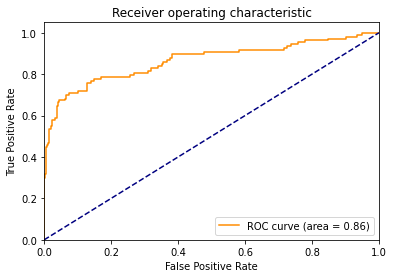

Optimal prediction threshold: 0.89863
Optimal prediction threshold: 0.20569
AUC for MCI vs. CN = 0.77
AUC for AD vs. CN = 0.97
AUC for MCI vs. CN = 0.766
AUC for AD vs. CN = 0.965
Acc for MCI vs. CN = 83.5
Acc for AD vs. CN = 88.3
confusion matrix (naive)
[[279  37]
 [ 24  30]
 [  6  47]]
oAcc for MCI vs. CN = 87.6
oAcc for AD vs. CN = 87.0
confusion matrix (optimized)
[[295  21]
 [ 25  29]
 [  8  45]]
validating model newmodel/newmodel_wb_cv14.hdf5
Test accuracy: 80.38 %


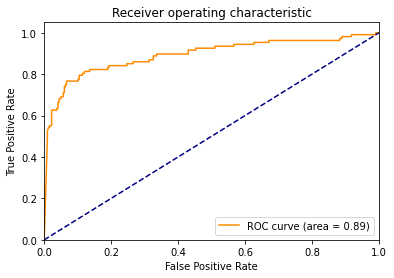

Optimal prediction threshold: 0.92159
Optimal prediction threshold: 0.99429
AUC for MCI vs. CN = 0.82
AUC for AD vs. CN = 0.96
AUC for MCI vs. CN = 0.821
AUC for AD vs. CN = 0.964
Acc for MCI vs. CN = 78.4
Acc for AD vs. CN = 81.3
confusion matrix (naive)
[[250  66]
 [ 14  40]
 [  3  50]]
oAcc for MCI vs. CN = 85.1
oAcc for AD vs. CN = 93.2
confusion matrix (optimized)
[[278  38]
 [ 17  37]
 [  4  49]]
validating model newmodel/newmodel_wb_cv15.hdf5
Test accuracy: 75.18 %


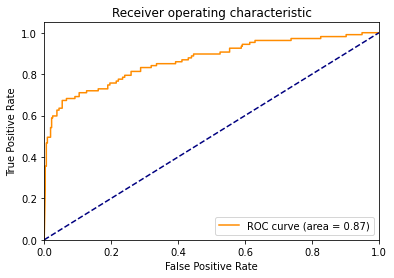

Optimal prediction threshold: 0.99337
Optimal prediction threshold: 0.99700
AUC for MCI vs. CN = 0.79
AUC for AD vs. CN = 0.95
AUC for MCI vs. CN = 0.786
AUC for AD vs. CN = 0.948
Acc for MCI vs. CN = 72.2
Acc for AD vs. CN = 76.4
confusion matrix (naive)
[[231  85]
 [ 18  36]
 [  2  51]]
oAcc for MCI vs. CN = 87.6
oAcc for AD vs. CN = 92.4
confusion matrix (optimized)
[[295  21]
 [ 25  29]
 [ 10  43]]
validating model newmodel/newmodel_wb_cv16.hdf5
Test accuracy: 81.09 %


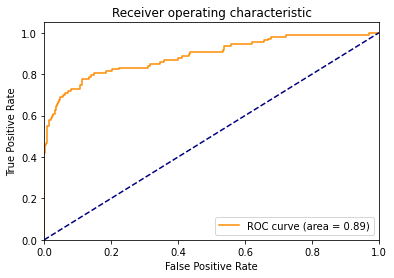

Optimal prediction threshold: 0.69521
Optimal prediction threshold: 0.97279
AUC for MCI vs. CN = 0.83
AUC for AD vs. CN = 0.95
AUC for MCI vs. CN = 0.827
AUC for AD vs. CN = 0.952
Acc for MCI vs. CN = 79.7
Acc for AD vs. CN = 82.4
confusion matrix (naive)
[[256  60]
 [ 15  39]
 [  5  48]]
oAcc for MCI vs. CN = 83.0
oAcc for AD vs. CN = 92.1
confusion matrix (optimized)
[[269  47]
 [ 16  38]
 [  6  47]]
validating model newmodel/newmodel_wb_cv17.hdf5
Test accuracy: 73.29 %


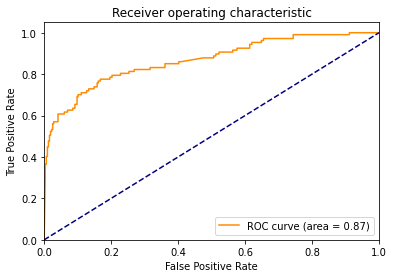

Optimal prediction threshold: 0.86349
Optimal prediction threshold: 0.92836
AUC for MCI vs. CN = 0.79
AUC for AD vs. CN = 0.94
AUC for MCI vs. CN = 0.794
AUC for AD vs. CN = 0.939
Acc for MCI vs. CN = 70.3
Acc for AD vs. CN = 73.7
confusion matrix (naive)
[[222  94]
 [ 16  38]
 [  3  50]]
oAcc for MCI vs. CN = 80.3
oAcc for AD vs. CN = 87.3
confusion matrix (optimized)
[[263  53]
 [ 20  34]
 [  5  48]]
validating model newmodel/newmodel_wb_cv18.hdf5
Test accuracy: 80.61 %


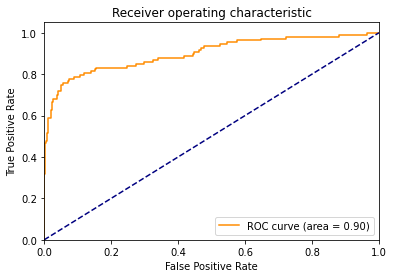

Optimal prediction threshold: 0.64966
Optimal prediction threshold: 0.99067
AUC for MCI vs. CN = 0.83
AUC for AD vs. CN = 0.97
AUC for MCI vs. CN = 0.833
AUC for AD vs. CN = 0.968
Acc for MCI vs. CN = 78.6
Acc for AD vs. CN = 81.8
confusion matrix (naive)
[[252  64]
 [ 15  39]
 [  3  50]]
oAcc for MCI vs. CN = 82.4
oAcc for AD vs. CN = 94.9
confusion matrix (optimized)
[[267  49]
 [ 16  38]
 [  3  50]]
validating model newmodel/newmodel_wb_cv19.hdf5
Test accuracy: 68.56 %


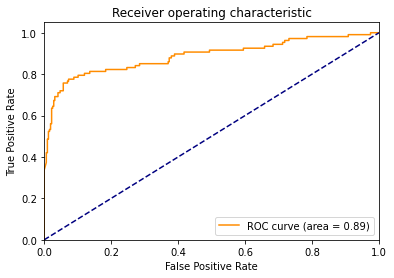

Optimal prediction threshold: 0.99241
Optimal prediction threshold: 0.99456
AUC for MCI vs. CN = 0.81
AUC for AD vs. CN = 0.96
AUC for MCI vs. CN = 0.812
AUC for AD vs. CN = 0.964
Acc for MCI vs. CN = 64.6
Acc for AD vs. CN = 66.9
confusion matrix (naive)
[[196 120]
 [ 11  43]
 [  2  51]]
oAcc for MCI vs. CN = 88.6
oAcc for AD vs. CN = 93.2
confusion matrix (optimized)
[[293  23]
 [ 19  35]
 [  6  47]]
validating model newmodel/newmodel_wb_cv20.hdf5
Test accuracy: 76.83 %


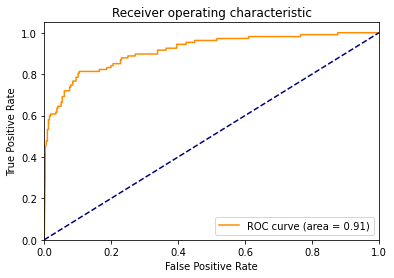

Optimal prediction threshold: 0.98764
Optimal prediction threshold: 0.99726
AUC for MCI vs. CN = 0.86
AUC for AD vs. CN = 0.97
AUC for MCI vs. CN = 0.856
AUC for AD vs. CN = 0.973
Acc for MCI vs. CN = 73.8
Acc for AD vs. CN = 76.2
confusion matrix (naive)
[[229  87]
 [ 10  44]
 [  1  52]]
oAcc for MCI vs. CN = 85.9
oAcc for AD vs. CN = 93.5
confusion matrix (optimized)
[[283  33]
 [ 19  35]
 [  2  51]]


In [8]:
# Split data into training/validation and holdout test data
from sklearn.model_selection import StratifiedKFold,train_test_split
import numpy as np
import gc
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" # model will be trained on GPU 0

import keras
from keras import layers
from keras.layers.normalization import BatchNormalization
from keras import models
from keras.optimizers import Adam
from keras import initializers
from keras.callbacks import EarlyStopping
import tensorflow as tf
from statistics import mean,stdev
from sklearn.metrics import confusion_matrix

acc_test, auc_test, auc_AD, auc_MCI = [], [], [], []
acc_AD, acc_MCI, opt_acc_AD, opt_acc_MCI = [], [], [], []
grps['pred'] = np.nan #-1
sen_AD, sen_MCI, spec_AD, spec_MCI = [], [], [], []
ppv_AD, ppv_MCI, npv_AD, npv_MCI = [], [], [], []
opt_ppv_AD, opt_ppv_MCI, opt_npv_AD, opt_npv_MCI = [], [], [], []
opt_sen_AD, opt_sen_MCI, opt_spec_AD, opt_spec_MCI = [], [], [], []
f1_AD, f1_MCI, opt_f1_AD, opt_f1_MCI = [], [], [], []

num_kfold = 20 # number of cross-validation loops equal to number of models
batch_size = 8

for k in range(num_kfold):
    gc.collect()
    print('validating model newmodel/newmodel_wb_cv%d.hdf5' % (k+1))
    mymodel = models.load_model('newmodel/newmodel_wb_cv%d.hdf5' % (k+1))
    
    # Calculate accuracy for validation data
    #scores = mymodel.evaluate(images, labels, batch_size=batch_size) #, verbose=0
    #print("Test %s: %.2f%%" % (mymodel.metrics_names[1], scores[1]*100))
    #acc_test.append(scores[1]*100)
    test_idX = np.array(range(amy_filter.shape[1]))[np.squeeze(amy_filter)] # filter index vector by amy status
    testgrps = grps.iloc[test_idX, :]
    testdat = images[test_idX, :]
    test_Y = labels[test_idX, :]
    
    # calculate area under the curve
    # AUC as optimization function during training: https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
    pred = mymodel.predict(testdat, batch_size=batch_size)
    grps.iloc[test_idX, 2] = pred[:, 1]
    acc_all = np.mean((test_Y[:, 1] == np.round(pred[:, 1])).astype(int))*100
    print("Test accuracy: %.2f %%" % acc_all)
    acc_test.append(acc_all)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    acc = dict()
    opt_acc = dict()
    thresh = dict()
    for i in range(2): # classes dummy vector: 0 - CN, 1 - MCI/AD
        fpr[i], tpr[i], _ = roc_curve(test_Y[:, i], pred[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot(fpr[1], tpr[1], color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    auc_test.append(roc_auc[1])
    
    # redo AUC for binary comparison: AD vs. HC and MCI vs. HC
    for i in [2,3]:
      grpi = np.equal(testgrps.Group.to_numpy(dtype=np.int), np.ones((testgrps.shape[0],), dtype=np.int)*i)
      grp1 = np.equal(testgrps.Group.to_numpy(dtype=np.int), np.ones((testgrps.shape[0],), dtype=np.int))
      grpidx = np.logical_or(grpi, grp1)
      fpr[i], tpr[i], thresholds = roc_curve(test_Y[grpidx, 1], pred[grpidx, 1])
      roc_auc[i] = auc(fpr[i], tpr[i])
      thresh[i] = thresholds[np.argmax(tpr[i] - fpr[i])]
      print('Optimal prediction threshold: %0.5f' % thresh[i])
      acc[i] = np.mean((test_Y[grpidx, 1] == np.round(pred[grpidx, 1])).astype(int))*100
      opt_acc[i] = np.mean((test_Y[grpidx, 1] == (pred[grpidx, 1]>thresh[i]).astype(int)).astype(int))*100

    print('AUC for MCI vs. CN = %0.2f' % roc_auc[2])
    print('AUC for AD vs. CN = %0.2f' % roc_auc[3])
    auc_AD.append(roc_auc[3])
    auc_MCI.append(roc_auc[2])
    acc_AD.append(acc[3])
    acc_MCI.append(acc[2])
    opt_acc_AD.append(opt_acc[3])
    opt_acc_MCI.append(opt_acc[2])
    
    print('AUC for MCI vs. CN = %0.3f' % roc_auc[2])
    print('AUC for AD vs. CN = %0.3f' % roc_auc[3])
    print('Acc for MCI vs. CN = %0.1f' % acc[2])
    print('Acc for AD vs. CN = %0.1f' % acc[3])
    print('confusion matrix (naive)')
    confmat = confusion_matrix(testgrps.Group-1, np.round(pred[:, 1]))
    sen, spec, ppv, npv, f1 = get_values(confmat[(0,1),0:2]) # MCI
    sen_MCI.append(sen); spec_MCI.append(spec); ppv_MCI.append(ppv); npv_MCI.append(npv); f1_MCI.append(f1)
    sen, spec, ppv, npv, f1 = get_values(confmat[(0,2),0:2]) # AD
    sen_AD.append(sen); spec_AD.append(spec); ppv_AD.append(ppv); npv_AD.append(npv); f1_AD.append(f1)
    print(confmat[:,(0,1)])
    print('oAcc for MCI vs. CN = %0.1f' % opt_acc[2])
    print('oAcc for AD vs. CN = %0.1f' % opt_acc[3])
    print('confusion matrix (optimized)')
    confmat = confusion_matrix(testgrps.Group-1, (pred[:, 1]>thresh[2]).astype(int)) ## use MCI threshold
    sen, spec, ppv, npv, f1 = get_values(confmat[(0,1),0:2]) # MCI
    opt_sen_MCI.append(sen); opt_spec_MCI.append(spec); opt_ppv_MCI.append(ppv); opt_npv_MCI.append(npv); opt_f1_MCI.append(f1)
    sen, spec, ppv, npv, f1 = get_values(confmat[(0,2),0:2]) # AD
    opt_sen_AD.append(sen); opt_spec_AD.append(spec); opt_ppv_AD.append(ppv); opt_npv_AD.append(npv); opt_f1_AD.append(f1)
    print(confmat[:,(0,1)])

In [9]:
# print model performance summary
from statistics import mean,stdev
print('Acc for all test data = %0.1f +/- %0.1f' % (mean(acc_test), stdev(acc_test)))
print('AUC for all test data = %0.3f +/- %0.3f' % (mean(auc_test), stdev(auc_test)))
print('AUC for MCI vs. CN = %0.3f +/- %0.3f' % (mean(auc_MCI), stdev(auc_MCI)))
print('AUC for AD vs. CN = %0.3f +/- %0.3f' % (mean(auc_AD), stdev(auc_AD)))
print('Mean Acc for MCI vs. CN = %0.1f +/- %0.1f' % (mean(acc_MCI), stdev(acc_MCI)))
print('Mean Acc for AD vs. CN = %0.1f +/- %0.1f' % (mean(acc_AD), stdev(acc_AD)))
print('Mean oAcc for MCI vs. CN = %0.1f +/- %0.1f' % (mean(opt_acc_MCI), stdev(opt_acc_MCI)))
print('Mean oAcc for AD vs. CN = %0.1f +/- %0.1f' % (mean(opt_acc_AD), stdev(opt_acc_AD)))

Acc for all test data = 75.8 +/- 4.6
AUC for all test data = 0.885 +/- 0.016
AUC for MCI vs. CN = 0.813 +/- 0.028
AUC for AD vs. CN = 0.958 +/- 0.009
Mean Acc for MCI vs. CN = 73.0 +/- 5.5
Mean Acc for AD vs. CN = 76.2 +/- 6.0
Mean oAcc for MCI vs. CN = 85.1 +/- 3.4
Mean oAcc for AD vs. CN = 90.5 +/- 2.8


In [10]:
results = pd.DataFrame({'Accuracy_Test':acc_test, 'AUC_Test':auc_test, 'AUC_MCI':auc_MCI, 'AUC_AD':auc_AD,
                        'Acc_MCI':acc_MCI, 'Acc_AD':acc_AD,
                        'Opt_acc_MCI':opt_acc_MCI, 'Opt_acc_AD':opt_acc_AD})
print(results)

    Accuracy_Test  AUC_Test   AUC_MCI    AUC_AD    Acc_MCI     Acc_AD  \
0       76.359338  0.904413  0.851383  0.958443  73.783784  75.880759   
1       68.321513  0.880619  0.818038  0.944381  64.054054  66.395664   
2       75.886525  0.859281  0.762072  0.958323  72.972973  76.151762   
3       75.413712  0.896279  0.830726  0.963070  72.162162  74.796748   
4       76.122931  0.886712  0.820822  0.953845  73.513514  76.964770   
5       69.739953  0.883414  0.811680  0.956502  65.945946  68.563686   
6       79.905437  0.880368  0.802215  0.959995  77.837838  82.113821   
7       76.595745  0.894963  0.840659  0.950293  74.054054  76.964770   
8       81.796690  0.888753  0.811006  0.967966  79.729730  84.281843   
9       70.212766  0.904738  0.849830  0.960682  66.216216  68.563686   
10      70.921986  0.877884  0.797996  0.959279  67.297297  70.189702   
11      73.758865  0.859813  0.771537  0.949755  71.081081  75.067751   
12      84.160757  0.864575  0.765940  0.965070  83

In [11]:
print('Mean Sen for MCI vs. CN = %0.3f +/- %0.3f' % (mean(sen_MCI), stdev(sen_MCI)))
print('Mean Sen for AD vs. CN = %0.3f +/- %0.3f' % (mean(sen_AD), stdev(sen_AD)))
print('Mean oSen for MCI vs. CN = %0.3f +/- %0.3f' % (mean(opt_sen_MCI), stdev(opt_sen_MCI)))
print('Mean oSen for AD vs. CN = %0.3f +/- %0.3f' % (mean(opt_sen_AD), stdev(opt_sen_AD)))

print('Mean Spec for MCI vs. CN = %0.3f +/- %0.3f' % (mean(spec_MCI), stdev(spec_MCI)))
print('Mean Spec for AD vs. CN = %0.3f +/- %0.3f' % (mean(spec_AD), stdev(spec_AD)))
print('Mean oSpec for MCI vs. CN = %0.3f +/- %0.3f' % (mean(opt_spec_MCI), stdev(opt_spec_MCI)))
print('Mean oSpec for AD vs. CN = %0.3f +/- %0.3f' % (mean(opt_spec_AD), stdev(opt_spec_AD)))

print('Mean PPV for MCI vs. CN = %0.3f +/- %0.3f' % (mean(ppv_MCI), stdev(ppv_MCI)))
print('Mean PPV for AD vs. CN = %0.3f +/- %0.3f' % (mean(ppv_AD), stdev(ppv_AD)))
print('Mean oPPV for MCI vs. CN = %0.3f +/- %0.3f' % (mean(opt_ppv_MCI), stdev(opt_ppv_MCI)))
print('Mean oPPV for AD vs. CN = %0.3f +/- %0.3f' % (mean(opt_ppv_AD), stdev(opt_ppv_AD)))

print('Mean NPV for MCI vs. CN = %0.3f +/- %0.3f' % (mean(npv_MCI), stdev(npv_MCI)))
print('Mean NPV for AD vs. CN = %0.3f +/- %0.3f' % (mean(npv_AD), stdev(npv_AD)))
print('Mean oNPV for MCI vs. CN = %0.3f +/- %0.3f' % (mean(opt_npv_MCI), stdev(opt_npv_MCI)))
print('Mean oNPV for AD vs. CN = %0.3f +/- %0.3f' % (mean(opt_npv_AD), stdev(opt_npv_AD)))

print('Mean F1 for MCI vs. CN = %0.3f +/- %0.3f' % (mean(f1_MCI), stdev(f1_MCI)))
print('Mean F1 for AD vs. CN = %0.3f +/- %0.3f' % (mean(f1_AD), stdev(f1_AD)))
print('Mean oF1 for MCI vs. CN = %0.3f +/- %0.3f' % (mean(opt_f1_MCI), stdev(opt_f1_MCI)))
print('Mean oF1 for AD vs. CN = %0.3f +/- %0.3f' % (mean(opt_f1_AD), stdev(opt_f1_AD)))

Mean Sen for MCI vs. CN = 0.731 +/- 0.070
Mean Sen for AD vs. CN = 0.951 +/- 0.025
Mean oSen for MCI vs. CN = 0.630 +/- 0.071
Mean oSen for AD vs. CN = 0.888 +/- 0.059
Mean Spec for MCI vs. CN = 0.730 +/- 0.073
Mean Spec for AD vs. CN = 0.730 +/- 0.073
Mean oSpec for MCI vs. CN = 0.888 +/- 0.048
Mean oSpec for AD vs. CN = 0.888 +/- 0.048
Mean PPV for MCI vs. CN = 0.325 +/- 0.051
Mean PPV for AD vs. CN = 0.382 +/- 0.067
Mean oPPV for MCI vs. CN = 0.516 +/- 0.109
Mean oPPV for AD vs. CN = 0.592 +/- 0.107
Mean NPV for MCI vs. CN = 0.941 +/- 0.011
Mean NPV for AD vs. CN = 0.989 +/- 0.005
Mean oNPV for MCI vs. CN = 0.934 +/- 0.009
Mean oNPV for AD vs. CN = 0.980 +/- 0.009
Mean F1 for MCI vs. CN = 0.724 +/- 0.029
Mean F1 for AD vs. CN = 0.823 +/- 0.041
Mean oF1 for MCI vs. CN = 0.733 +/- 0.040
Mean oF1 for AD vs. CN = 0.885 +/- 0.020
